# Exploration in Reinforcement Learning

In [1]:
!rm -rf mvarl_hands_on/
!git clone https://github.com/rlgammazero/mvarl_hands_on.git
!cd mvarl_hands_on/ && git fetch

Cloning into 'mvarl_hands_on'...


In [2]:
import sys
sys.path.insert(0, './mvarl_hands_on/utils')
import os
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import math
from gridworld import GridWorldWithPits
from tqdm import tqdm
import copy

## Finite-Horizon Tabular MDPs
We consider finite horizon problems with horizon $H$.For simplicity, we consider MDPs with stationary transitions and rewards, ie these functions do not depend on the stage ($p_h =p$, $r_h=r$ for any $h \in [H]$).

The value of a policy or the optimal value function can be computed using *backward induction*.


Given a deterministic (non-stationary) policy $\pi = (\pi_1, \pi_2, \ldots, \pi_H)$, backward induction applies the Bellman operator defined as
$$
V_h^\pi(s) = \sum_{s'} p(s'|s,\pi_h(s)) \left( r(s,\pi_h(s),s') + V_{h+1}^\pi(s')\right)
$$
where $V_{H+1}(s) = 0$, for any $s$. 




Suggestion:
- $V$ -> $(H+1, S)$-dimensional matrix
- deterministic policy $\pi$ -> $(H, S)$-dimensional matrix

**backward induction for $V^\pi$ and $V^\star$**  

In [3]:
def evaluate_policy(P, R, H, policy):
    """
        Parameters:
            P: transition function (S,A,S)-dim matrix
            R: reward function (S,A,S)-dim matrix
            H: horizon
            policy: a deterministic policy (H, S)-dim matrix
            
        Returns:
            The V-function of the provided policy
    """
    S, A = P.shape[0], P.shape[1]
    V=np.zeros((H+1,S))
    for h in reversed(range(H)):
      #Using matrix operations is much faster than doing loops 
      #as these operations are well optimized in numpy
      V[h]=np.sum(P[np.arange(S),policy[h]]*(R[np.arange(S),policy[h]]+V[h+1]),axis=1)
    return V

def backward_induction(P, R, H):
    """
        Parameters:
            P: transition function (S,A,S)-dim matrix
            R: reward function (S,A,S)-dim matrix
            H: horizon
            
        Returns:
            The optimal V-function
            The optimal policy
    """
    S, A = P.shape[0], P.shape[1]
    Q=np.zeros((H+1,S,A))
    V=np.zeros((H+1,S))
    policy=np.zeros((H,S),dtype=int)

    for h in reversed(range(H)):
      #Using matrix operations is much faster than doing loops 
      #as these operations are well optimized in numpy
      Q[h]=np.sum(P*(R+V[h+1]),axis=2)
      policy[h]= np.argmax(Q[h],axis=1)
      V[h]=Q[h,np.arange(S),policy[h]]
    return V, policy

Let's set up the environment

In [4]:
grid1 = [
    ['', '', '', 'g'],
    ['', 'x', '', ''],
    ['s', '', '', '']
]
grid1_MAP = [
    "+-------+",
    "| : : :G|",
    "| :x: : |",
    "|S: : : |",
    "+-------+",
]


env = GridWorldWithPits(grid=grid1, txt_map=grid1_MAP, uniform_trans_proba=0)
H = 6
env.render()

+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+



We should test previous functions

In [5]:
V, optimal_pol = backward_induction(env.P, env.R, H)
print(V)
Vpi = evaluate_policy(env.P, env.R, H, optimal_pol)
print(Vpi)
assert np.allclose(V, Vpi)

[[3.98342174 3.98668316 3.99888469 3.99900565 3.93845103 3.38442821
  3.98743386 3.99907706 3.91567934 3.95432206 3.99516932 3.99818051]
 [3.35518231 3.38566532 3.39841218 3.39933889 3.31201648 2.75064778
  3.38668694 3.39869023 2.99900565 3.32685495 3.37162833 3.39692963]
 [2.73311111 2.762375   2.79823611 2.79966667 2.38934167 2.144975
  2.76311944 2.79840833 2.39933889 2.38934167 2.74873056 2.77888611]
 [1.79966667 2.15083333 2.186      2.2        1.78983333 1.19
  2.15733333 2.18616667 1.79966667 1.78983333 1.79966667 2.161     ]
 [1.2        1.19       1.58       1.6        1.19       0.6
  1.19       1.58       1.2        1.19       1.2        1.2       ]
 [0.6        0.6        0.6        1.         0.6        0.
  0.6        0.6        0.6        0.6        0.6        0.6       ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]]
[[3.98342174 3.98668316 3.99888469 3.99900565 3.93845103 3.38442821
  3

Run the policy

In [6]:
state = env.reset()
env.render()
for i in range(H):
    next_state, reward, _, _ = env.step(optimal_pol[i, state])
    env.render()
    state = next_state

+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+

+-------+
| : : :G|
| :x: : |
|S:_: : |
+-------+
  (right)
+-------+
| : : :G|
| :x: : |
|S: :_: |
+-------+
  (right)
+-------+
| : : :G|
| :x: : |
|S: : :_|
+-------+
  (right)
+-------+
| : : :G|
| :x: :_|
|S: : : |
+-------+
  (up)
+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+
  (up)
+-------+
| : : :G|
| :x: : |
|S: : : |
+-------+
  (right)


Finally we are ready to implement our exploration algorithm.
## UCB-VI ALgorithm:

UCBVI is an algorithm for efficient exploration in finite-horizon tabular MDP.
In this setting, the regret is defined as
$$R(K) = \sum_{k=1}^K V^\star_1(s_{k,1}) - V^{\pi_k}_1(s_{k,1})$$
UCBVI enjoys a regret bound of order $O(\sqrt{HSAK})$.

The structure of the algorithm is as follow

For $k = 1, \ldots, K$ do<br>
> Solve optimistic planning problem -> $(V_k, Q_k, \pi_k)$<br>
> Execute the optimistic policy $\pi_k$ for $H$ steps<br>
>> for $h=1, \ldots, H$<br>
>>> $a_{k,h} = \pi(s_{k,h})$<br>
>>> execute $a_{k,h}$, observe $r_{k,h}$ and $s_{k, h+1}$<br>
>>> $N(s_{k,h}, a_{k,h}, s_{k,h+1}) += 1$ (update also estimated reward and transitions)

<font color='#ed7d31'>Optimistic planning</font>

UCBVI exploits exploration bonus to perform optimistic planning on the empirical MDP $(\hat{p}, \hat{r})$.
The optimal Q-function of this MDP can be obtained using backward induction.

The optimal Bellman operator for Q-function is defined similarly as
$$
Q_h^\star(s,a) =  b(s,a) + \sum_{s'} p(s'|s,a) \left( r(s,a,s') + \max_{a'} Q_{h+1}^\star(s',a')\right) 
$$
where $Q_{H+1}(s,a) = 0$ and $b$ is an exploration bonus.

<font color='#ed7d31'>Exploration Bonus</font>

Using Hoeffding's bound we have that
$$
b_{k,h}(s,a) = 7(H-h+1)L\sqrt{\frac{1}{N_k(s,a)}}
$$
where $L = \ln(5SAT/\delta)$.

A tighter exploration bonus is obtained using <b>Bernstein's bound</b>. 

Refer to [Minimax Regret Bounds for Reinforcement Learning](https://arxiv.org/abs/1703.05449) for additional details.


In [7]:
class UCBVI:
    
    def __init__(self, config):
        np.random.seed(seed=config['seed'])
        self.env = config['env']
        self.horizon = config['horizon']
        self.scale_factor = config['scale_factor']
        self.nb_repetitions = config['repetitions']
        self.nb_episodes = config['episodes']
        assert config['b_type'] in ['hoeffding', 'bernstein']
        self.b_type = config['b_type']
        self.reset()

    def reset(self):
        S, A = self.env.Ns, self.env.Na
        self.delta = 0.1
        self.t = 0
        self.episode = 0
        self.Phat = np.zeros((S, A, S))
        self.Rhat = np.zeros((S, A, S))
        self.N_sa = np.zeros((S, A), dtype=np.int)
        self.N_sas = np.zeros((S, A, S), dtype=np.int)
        self.policy = np.zeros((self.horizon, S), dtype=np.int)
        self.V = np.zeros((self.horizon+1, S))
        self.Q = np.zeros((self.horizon+1, S, A))
        self.bonus = np.zeros((self.horizon, S, A))
        
    def get_optimistic_q(self):
        """ Compute optimistic Q-function and associated greedy policy
        """
        H = self.horizon
        S, A = self.N_sa.shape
        self.V.fill(0)
        self.Q.fill(0)
        if self.b_type=='hoeffding':
          self.compute_hoeffding_bonus()
        for h in reversed(range(H)):
          if self.b_type=='bernstein':
            self.compute_bernstein_bonus(h,self.V[h+1])
          #again avoiding loops here is more efficient
          self.Q[h]=self.bonus[h]+np.sum(self.Phat*(self.Rhat+np.max(self.Q[h+1],axis=1)),axis=2)
          self.policy[h]= np.argmax(self.Q[h],axis=1)
          self.V[h]=self.Q[h,np.arange(S),self.policy[h]]
          self.V[h]=np.minimum(H-h+2,self.V[h])
                
    def compute_hoeffding_bonus(self):
        """Compute Hoeffding-based exploration bonus
        """
        S, A = self.N_sa.shape
        L = np.log(5*S*A*max(1,self.t)/self.delta)
        for h in range(H):
          self.bonus[h]=7*(H-h+1)*L*np.sqrt(1/np.maximum(1,self.N_sa))
        
        
    def compute_bernstein_bonus(self, h, Vhp1):
        """Compute Bernstein-based exploration bonus

        Parameters:
            h: state
            Vhp1: value function at state h+1 (S-dim vector)
        """
        S, A = self.N_sa.shape
        for s in range(S):
            for a in range(A):
                L = np.log(5 * S * A * max(1, self.N_sa[s][a]) / self.delta)
                n = max(1, self.N_sa[s][a])
                var, mean = 0, 0
                for i in range(S):
                    mean += self.Phat[s,a,i] * Vhp1[i]
                for i in range(S):
                    var += self.Phat[s,a,i] * (Vhp1[i] - mean) * (Vhp1[i] - mean)
                T1 = np.sqrt(8 * L * var / n) + 14 * L * (self.horizon -h + 2) / (3*n)
                T2 = np.sqrt(8 * (self.horizon -h + 2)**2  / n)
                self.bonus[h,s,a] = self.scale_factor * (T1 + T2)

    def update(self, state, action, reward, next_state):
        """Update the internal statistics
        """
        self.Rhat[state,action,next_state]=(self.Rhat[state,action,next_state]*self.N_sas[state,action,next_state]+reward)/(self.N_sas[state,action,next_state]+1)
        self.N_sas[state,action,next_state]+=1
        self.Phat[state,action]=self.N_sas[state,action]/np.sum(self.N_sas[state,action])
        self.N_sa[state,action]+=1
    def run_episode(self):
        episode_reward = 0
        state = self.env.reset()
        initial_state = state
        self.get_optimistic_q()
        
        
        Vpi = evaluate_policy(self.env.P, self.env.R, self.horizon, self.policy)
        #self.episode_value.append(Vpi[0, initial_state])
        
        for h in range(self.horizon):
            action = self.policy[h, state]
            next_state, reward, done, info = self.env.step(action)
            self.update(state, action, reward, next_state)
            episode_reward += reward
            state = next_state
            self.t += 1
        self.episode += 1
        return initial_state, Vpi
    
    def train(self):
        # compute true value function (for the regret)
        trueV, _ = backward_induction(self.env.P, self.env.R, self.horizon)
        regret = np.zeros((self.nb_repetitions, self.nb_episodes+1))
        for rep in range(self.nb_repetitions):
            self.reset()
            old_regret = 0
            for k in range(self.nb_episodes):
                init_state, Vpi = self.run_episode()
                episode_regret = trueV[0,init_state]-Vpi[0,init_state]
                old_regret += episode_regret
                regret[rep, k+1] = old_regret
        return regret

Define the settings

In [8]:
config = {
    'env': env,
    'scale_factor': 0.1, # we use a scaling factor in order to increase the convergence speed
    'seed': 14,
    'horizon': H,
    'episodes': 4000,
    'repetitions': 5,
    'b_type': 'hoeffding' # [hoeffding, bernstein]
}

print("Current config is:")
pprint(config)

Current config is:
{'b_type': 'hoeffding',
 'env': <gridworld.GridWorldWithPits object at 0x000001CB62D41608>,
 'episodes': 4000,
 'horizon': 6,
 'repetitions': 5,
 'scale_factor': 0.1,
 'seed': 14}


Run the agent and compare the behaviour with Hoeffding and Bernstein bound.

A picture is automatically generated (it will show the regret average regret of the two algorithms)

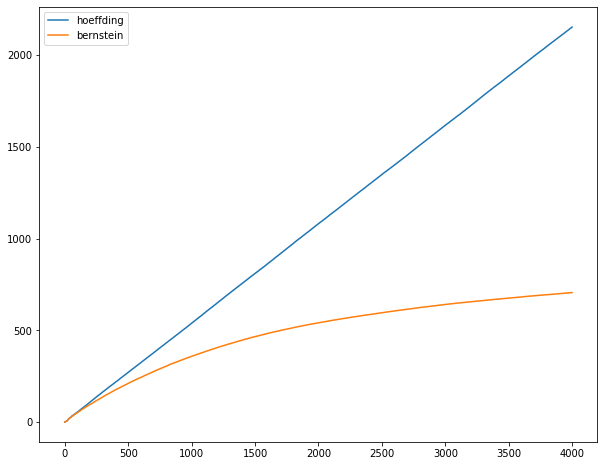

In [9]:
plt.figure(figsize=(10,8))
regret = {}
for bound in ['hoeffding', 'bernstein']:
    tmp_config = copy.copy(config) 
    tmp_config['b_type'] = bound
    agent = UCBVI(config=tmp_config)
    regret[bound] = agent.train()

    mean_regret = np.mean(regret[bound], axis=0)
    std = np.std(regret[bound], axis=0) / np.sqrt(regret[bound].shape[0])
    x = np.arange(regret[bound].shape[1])
    plt.plot(x, mean_regret, label=bound)
    plt.fill_between(x, mean_regret + 2 * std, mean_regret - 2 * std, alpha=0.15)
plt.legend()
